In [2]:
#!/home/neil.lu/.conda/envs/ringdown/bin/python
# coding: utf-8

import matplotlib.pyplot as pl
import numpy as np
import re
import qnm_filter
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import scipy as sp
import argparse
from natsort import natsorted
import glob
import astropy.units as u
import time
import os
import sys
import matplotlib
mplparams = {
    'text.usetex': True,
    'axes.linewidth': 1,
    'lines.linewidth' : 2.5,
    'lines.markersize': 13,
    'axes.grid': False,
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 26,
    'figure.figsize': (15,15),
    'legend.fontsize': 26,
    'legend.handlelength' : 2,
    'legend.numpoints' : 1,
    'axes.grid' : True,
    'grid.alpha' : 0.3,
}
matplotlib.rcParams.update(mplparams)

In [3]:
red = '#D60606'
blue = '#0083DE'
green = '#00BA75'
yellow = '#FFC61E'
purple = '#A433B3'
orange = '#FD882E'
color_arr = [red, blue, green, yellow, purple, orange]

In [4]:
thresh_dict = {
    '220+200:220': 6.34,
    '220+221:220': 4.85,
    '220+210:220': 6.63,
    '220+330:220': 5.02,
    '220+440:220': 6.43,
    '220:220' : -1000,
    '220+221+200:220+221' : 5.25,
    '220+221+210:220+221' : 8.61,
    '220+221+222:220+221' : 6.17,
    '220+221+330:220+221' : 4.79,
    '220+221+440:220+221' : 5.01, 
    '220+330+331:220+330' : 6.02,
    '220+330+221:220+330' : 5.39,
    '220+330+200:220+330' : 5.13,
    '220+330+210:220+330' : 5.70,
    '220+330+440:220+330' : 5.13,
}

for key in thresh_dict.keys():
    thresh_dict[key] = thresh_dict[key]/np.log(10)

In [25]:
def load_data(filename):
    likelihood_data = np.loadtxt(filename)
    evidence = sp.special.logsumexp(likelihood_data)
    
    # Metadata
    f = open(filename)
    header = f.readline()[2:]

    time_patt = r"time=(\d+\.\d+)"
    time_offset = float(re.search(time_patt, header).group(1))

    evidence_patt = r"evidence=(-?\d+\.\d+)"
    evidence = float(re.search(evidence_patt, header).group(1))

#     filter_patt = r"model_list=(.*?)\,"
#     filter_str = re.search(filter_patt, header).group(1)

    credible_patt = r"credible=(-\d+\.\d+)"
    credible = float(re.search(credible_patt, header).group(1))

    chi_patt = r"chi_bounds=\((\d+\.\d+)_(\d+\.\d+)\)"
    chi_match = re.search(chi_patt, header)
    chi_lower = float(chi_match.group(1))
    chi_upper = float(chi_match.group(2))

    mass_patt = r"mass_bounds=\((\d+)_(\d+)\)"
    mass_match = re.search(mass_patt, header)
    mass_lower = float(mass_match.group(1))
    mass_upper = float(mass_match.group(2))

    massspace = np.linspace(mass_lower, mass_upper, likelihood_data.shape[1], endpoint=False)
    chispace = np.linspace(chi_lower, chi_upper, likelihood_data.shape[0], endpoint=False)
    mass_grid, chi_grid = np.meshgrid(massspace, chispace)
    projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, np.diff(massspace)[0], np.diff(chispace)[0])
    
    return likelihood_data, evidence, time_offset, credible, \
            chi_lower, chi_upper, mass_lower, mass_upper, \
            massspace, chispace, mass_grid, chi_grid, projected_mass, projected_chi

In [23]:
filename = "results/0305_2mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

temp = {}
for idx, mode in enumerate(mode_list):
    temp[mode] = data[idx]

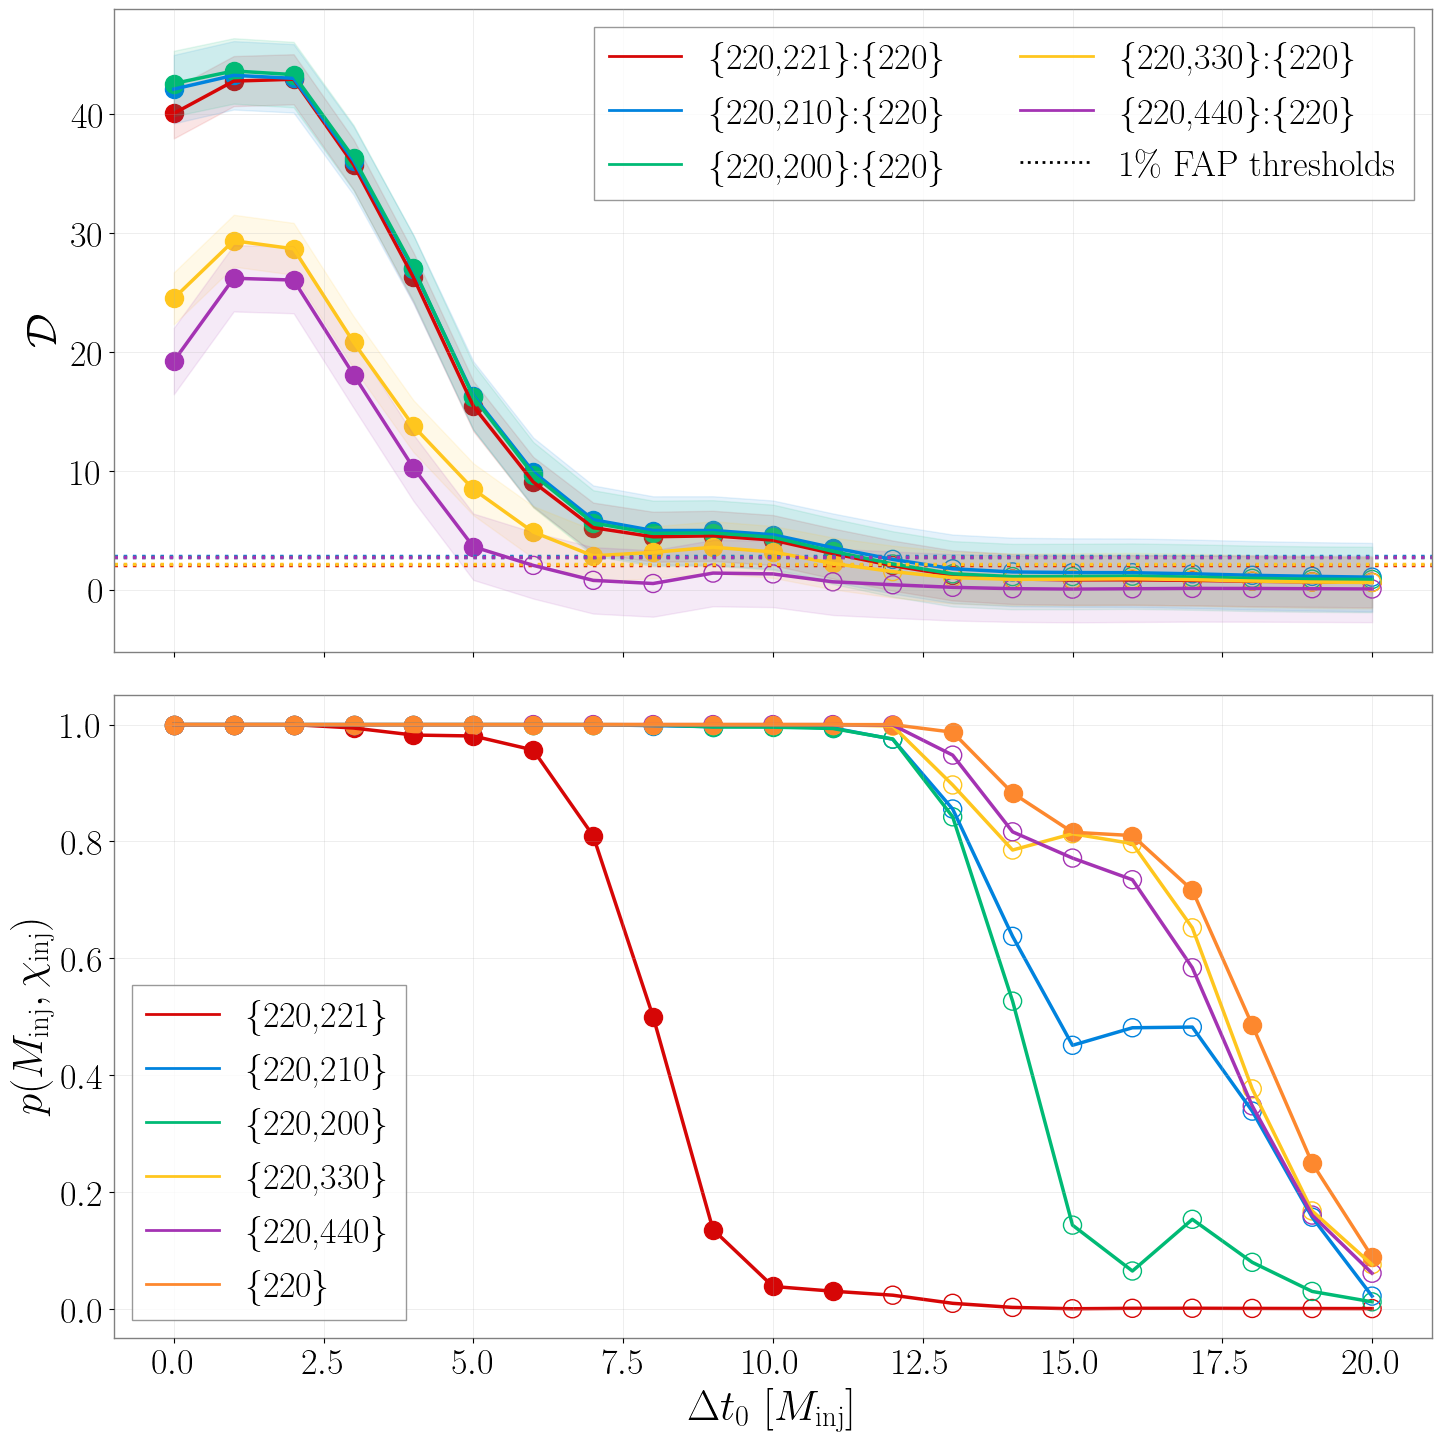

In [24]:
fig, axs = pl.subplots(2, sharex = True)
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
plotting = ["220+221", "220+210", "220+200", "220+330", "220+440", "220"]
plotting_label = ["\{220,221\}","\{220,210\}","\{220,200\}","\{220,330\}","\{220,440\}","\{220\}"]

filename = "results/0305_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
time_arr = data[-1]
BF_curves = data[:-1]/np.log(10)
BF_dict = dict(zip(mode_list, BF_curves))

for idx, mode in enumerate(plotting[:-1]):
    val = BF_dict[mode]
    thresh = thresh_dict[mode+':220']
    significant = val > thresh
    axs[0].plot(time_arr, val, label=plotting_label[idx]+':\{220\}', color=color_arr[idx])
    axs[0].scatter(time_arr[significant], val[significant], marker='o', color=color_arr[idx])
    axs[0].scatter(time_arr[np.logical_not(significant)], val[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[idx])
    axs[0].fill_between(time_arr, val-thresh_dict[mode_list[idx]+':220'], val+thresh_dict[mode_list[idx]+':220'],
                   alpha=0.1, color=color_arr[idx])
    axs[0].axhline(thresh,
                   alpha=1.0, color=color_arr[idx], ls=':')

axs[0].plot(np.nan, np.nan, ls=':', color = 'k', label='1\% FAP thresholds')
leg = axs[0].legend(ncols=2)
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel(r"$\mathcal{D}$")

filename = "results/0305_2mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
time_arr = data[-1]
pvalues = data[:-1]
pvalue_dict = dict(zip(mode_list, pvalues))

for idx, mode in enumerate(plotting[:-1]):
    quantiles = pvalue_dict[mode]
    thresh = thresh_dict[mode+':220']
    significant = BF_dict[mode] > thresh
    axs[1].plot(time_arr, quantiles , label=plotting_label[idx], color=color_arr[idx])
    axs[1].scatter(time_arr[significant], quantiles[significant], marker='o', color=color_arr[idx])
    axs[1].scatter(time_arr[np.logical_not(significant)], quantiles[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[idx])
axs[1].plot(time_arr, temp['220'] , label=plotting_label[-1], color=color_arr[-1])
axs[1].scatter(time_arr, temp['220'] , color=color_arr[-1])

    
leg = axs[1].legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ [$M_\textrm{\huge inj}$]')
axs[1].set_ylabel(r"$p(M_\textrm{\huge inj},\chi_\textrm{\huge inj})$")

pl.tight_layout()
pl.savefig("plots/0305_2mode_results.png")
pl.savefig("plots/0305_2mode_results.pdf")

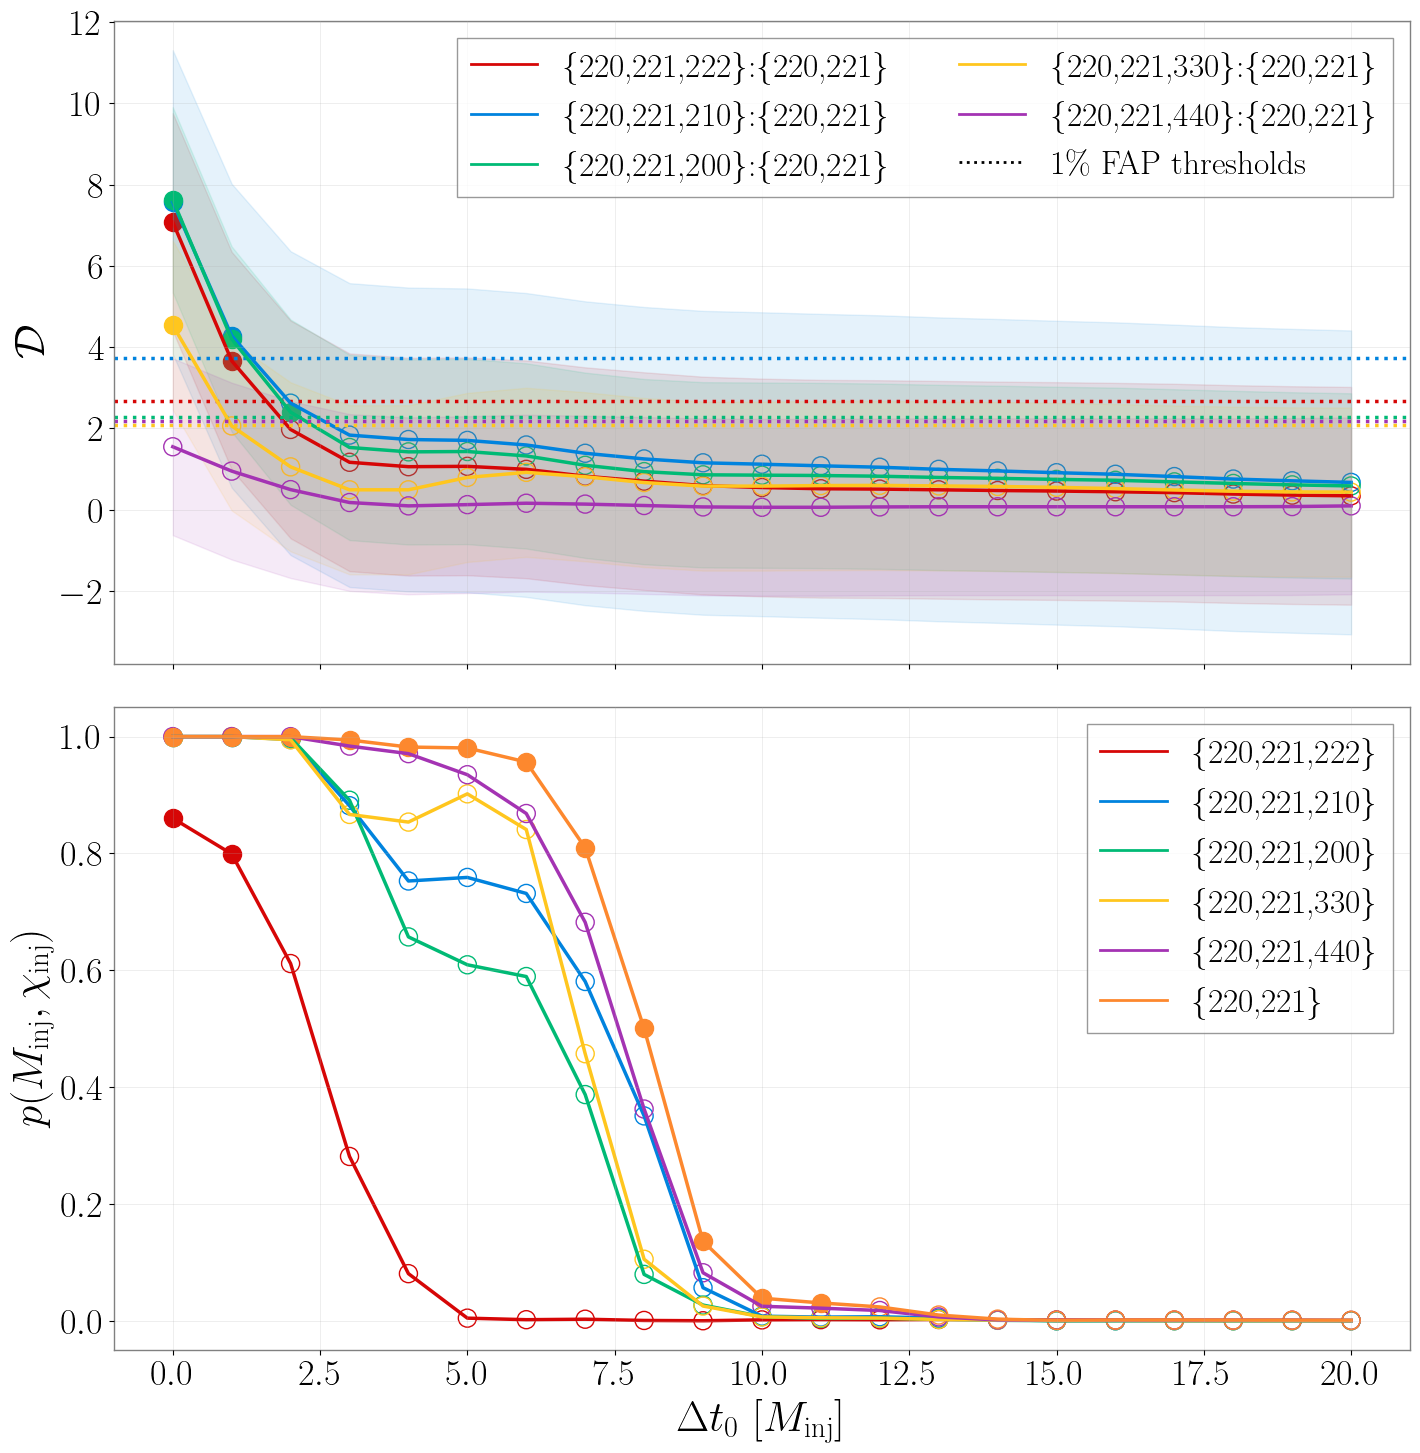

In [25]:
fig, axs = pl.subplots(2, sharex = True)
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
filename = "results/0305_3mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
plotting_label = ["\{220,221,222\}","\{220,221,210\}","\{220,221,200\}","\{220,221,330\}","\{220,221,440\}","\{220,221\}"]

time_arr = data[-1]
BF_curves = data[:-1]/np.log(10)
for idx, val in enumerate(BF_curves):
    thresh = thresh_dict[mode_list[idx]+':220+221']
    significant = val > thresh
    axs[0].plot(time_arr, val, label=plotting_label[idx]+':\{220,221\}', color=color_arr[idx])
    axs[0].scatter(time_arr[significant], val[significant], marker='o', color=color_arr[idx])
    axs[0].scatter(time_arr[np.logical_not(significant)], val[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[idx])
    axs[0].fill_between(time_arr, val-thresh, val+thresh,
                   alpha=0.1, color=color_arr[idx])
    axs[0].axhline(thresh,
                   alpha=1.0, color=color_arr[idx], ls=':')

axs[0].plot(np.nan, np.nan, ls=':', color = 'k', label='1\% FAP thresholds')
leg = axs[0].legend(ncols=2,fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel(r"$\mathcal{D}$")

filename = "results/0305_3mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]
for idx, val in enumerate(pvalues[:-1]):
    quantiles = val
    thresh = thresh_dict[mode_list[idx]+':220+221']
    significant = BF_curves[idx] > thresh
    axs[1].plot(time_arr, quantiles , label=plotting_label[idx], color=color_arr[idx])
    axs[1].scatter(time_arr[significant], quantiles[significant], marker='o', color=color_arr[idx])
    axs[1].scatter(time_arr[np.logical_not(significant)], quantiles[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[idx])

filename = "results/0305_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
time_arr = data[-1]
BF_curves = data[:-1]/np.log(10)
BF_dict = dict(zip(mode_list, BF_curves))

filename = "results/0305_3mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
time_arr = data[-1]
pvalues = data[:-1]
pvalue_dict = dict(zip(mode_list, pvalues))

#for the reference mode
ref_mode = "220+221"
thresh = thresh_dict[ref_mode+':220']
significant = BF_dict[ref_mode] > thresh
quantiles = pvalue_dict[ref_mode]

axs[1].plot(time_arr, quantiles , label=plotting_label[-1], color=color_arr[-1])
axs[1].scatter(time_arr[significant], quantiles[significant], marker='o', color=color_arr[-1])
axs[1].scatter(time_arr[np.logical_not(significant)], quantiles[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[-1])


leg = axs[1].legend(fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ [$M_\textrm{\huge inj}$]')
axs[1].set_ylabel(r"$p(M_\textrm{\huge inj},\chi_\textrm{\huge inj})$")

pl.tight_layout()
pl.savefig("plots/0305_3mode_results.pdf")
pl.savefig("plots/0305_3mode_results.png")

## 1107

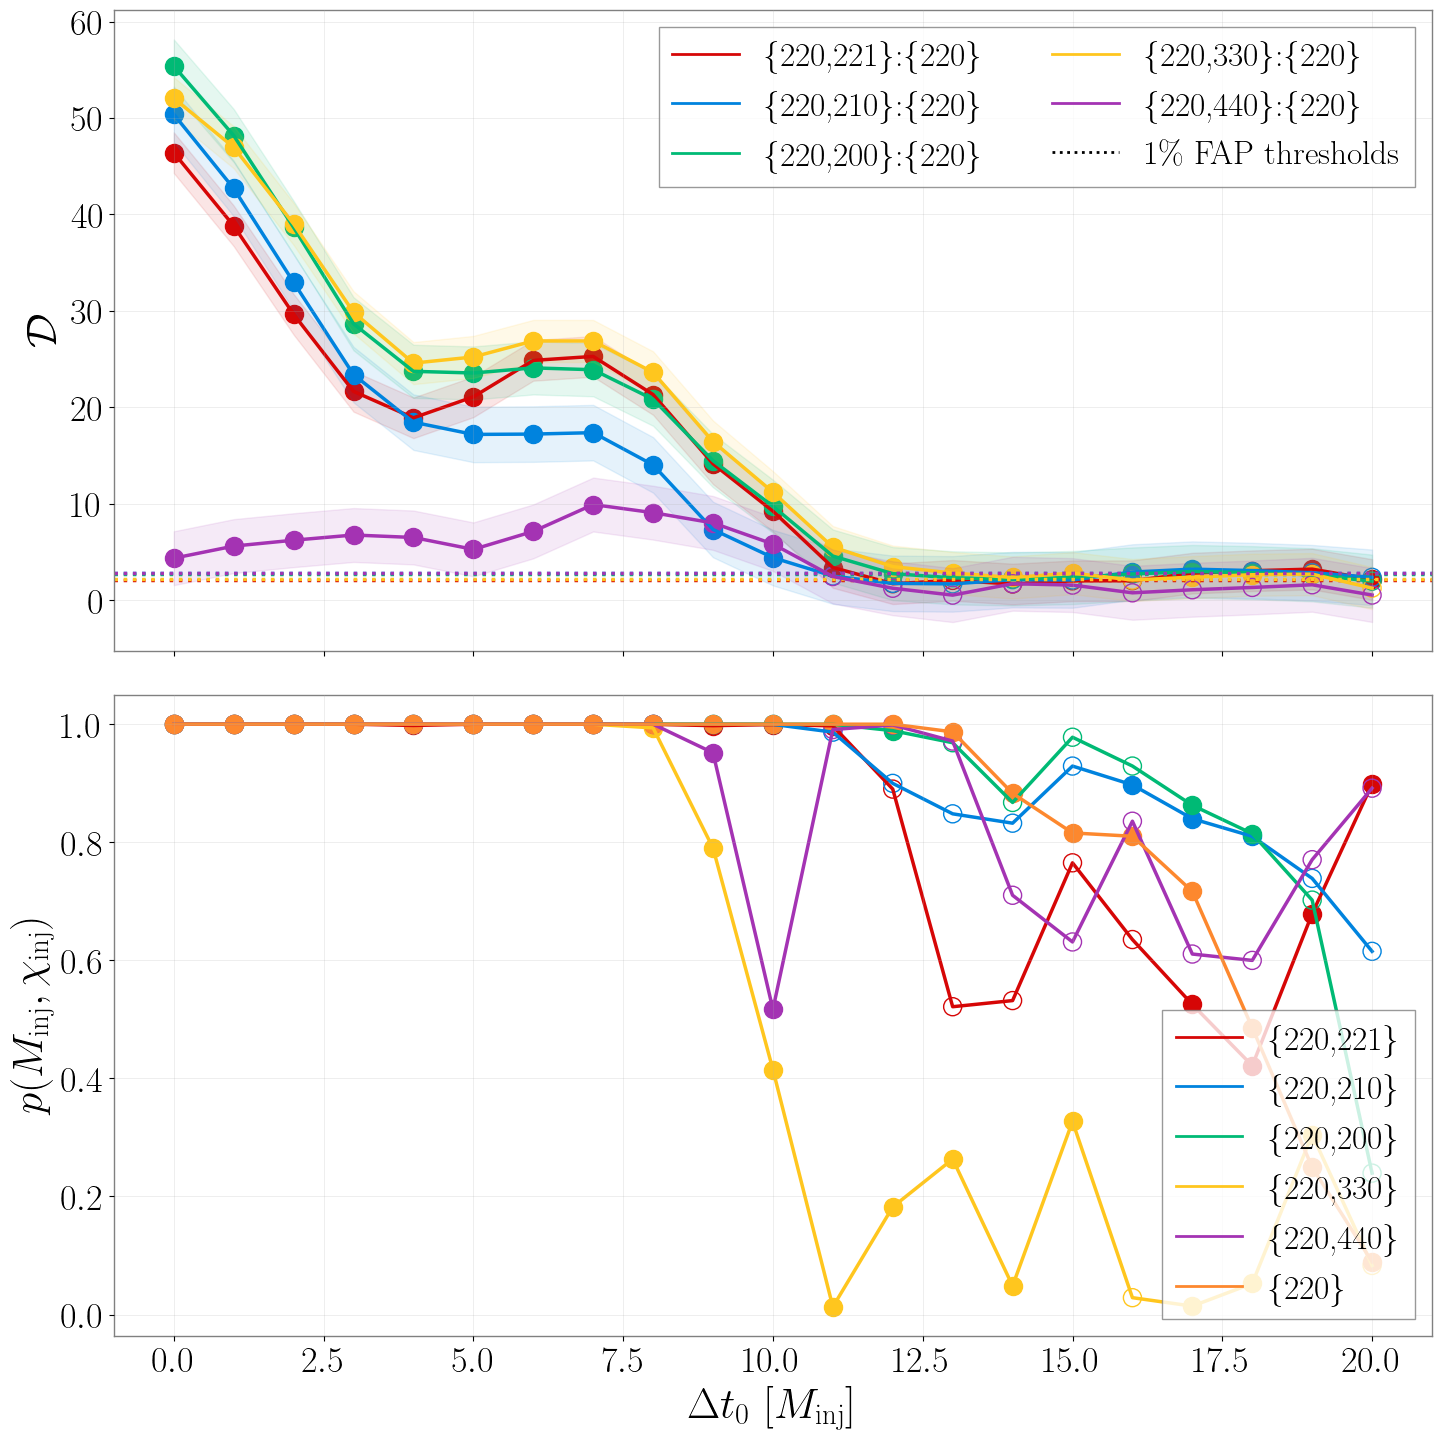

In [26]:
fig, axs = pl.subplots(2, sharex = True)
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
filename = "results/1107_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
plotting_label = ["\{220,221\}","\{220,210\}","\{220,200\}","\{220,330\}","\{220,440\}","\{220\}"]

time_arr = data[-1]
BF_curves = data[:-1]/np.log(10)
for idx, val in enumerate(BF_curves):
    thresh = thresh_dict[mode_list[idx]+':220']
    significant = val > thresh
    axs[0].plot(time_arr, val, label=plotting_label[idx]+':\{220\}', color=color_arr[idx])
    axs[0].scatter(time_arr[significant], val[significant], marker='o', color=color_arr[idx])
    axs[0].scatter(time_arr[np.logical_not(significant)], val[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[idx])
    axs[0].fill_between(time_arr, val-thresh, val+thresh,
                   alpha=0.1, color=color_arr[idx])
    axs[0].axhline(thresh,
                   alpha=1.0, color=color_arr[idx], ls=':')

axs[0].plot(np.nan, np.nan, ls=':', color = 'k', label='1\% FAP thresholds')
leg = axs[0].legend(ncols=2,fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel(r"$\mathcal{D}$")

filename = "results/1107_2mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]
for idx, val in enumerate(pvalues[:-1]):
    quantiles = val
    thresh = thresh_dict[mode_list[idx]+':220']
    significant = BF_curves[idx] > thresh
    axs[1].plot(time_arr, quantiles , label=plotting_label[idx], color=color_arr[idx])
    axs[1].scatter(time_arr[significant], quantiles[significant], marker='o', color=color_arr[idx])
    axs[1].scatter(time_arr[np.logical_not(significant)], quantiles[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[idx])
axs[1].plot(time_arr, temp['220'] , label=plotting_label[-1], color=color_arr[-1])
axs[1].scatter(time_arr, temp['220'] , color=color_arr[-1])

leg = axs[1].legend(loc='lower right', fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ [$M_\textrm{\huge inj}$]')
axs[1].set_ylabel(r"$p(M_\textrm{\huge inj},\chi_\textrm{\huge inj})$")

pl.tight_layout()
pl.savefig("plots/1107_2mode_results.pdf")
pl.savefig("plots/1107_2mode_results.png")

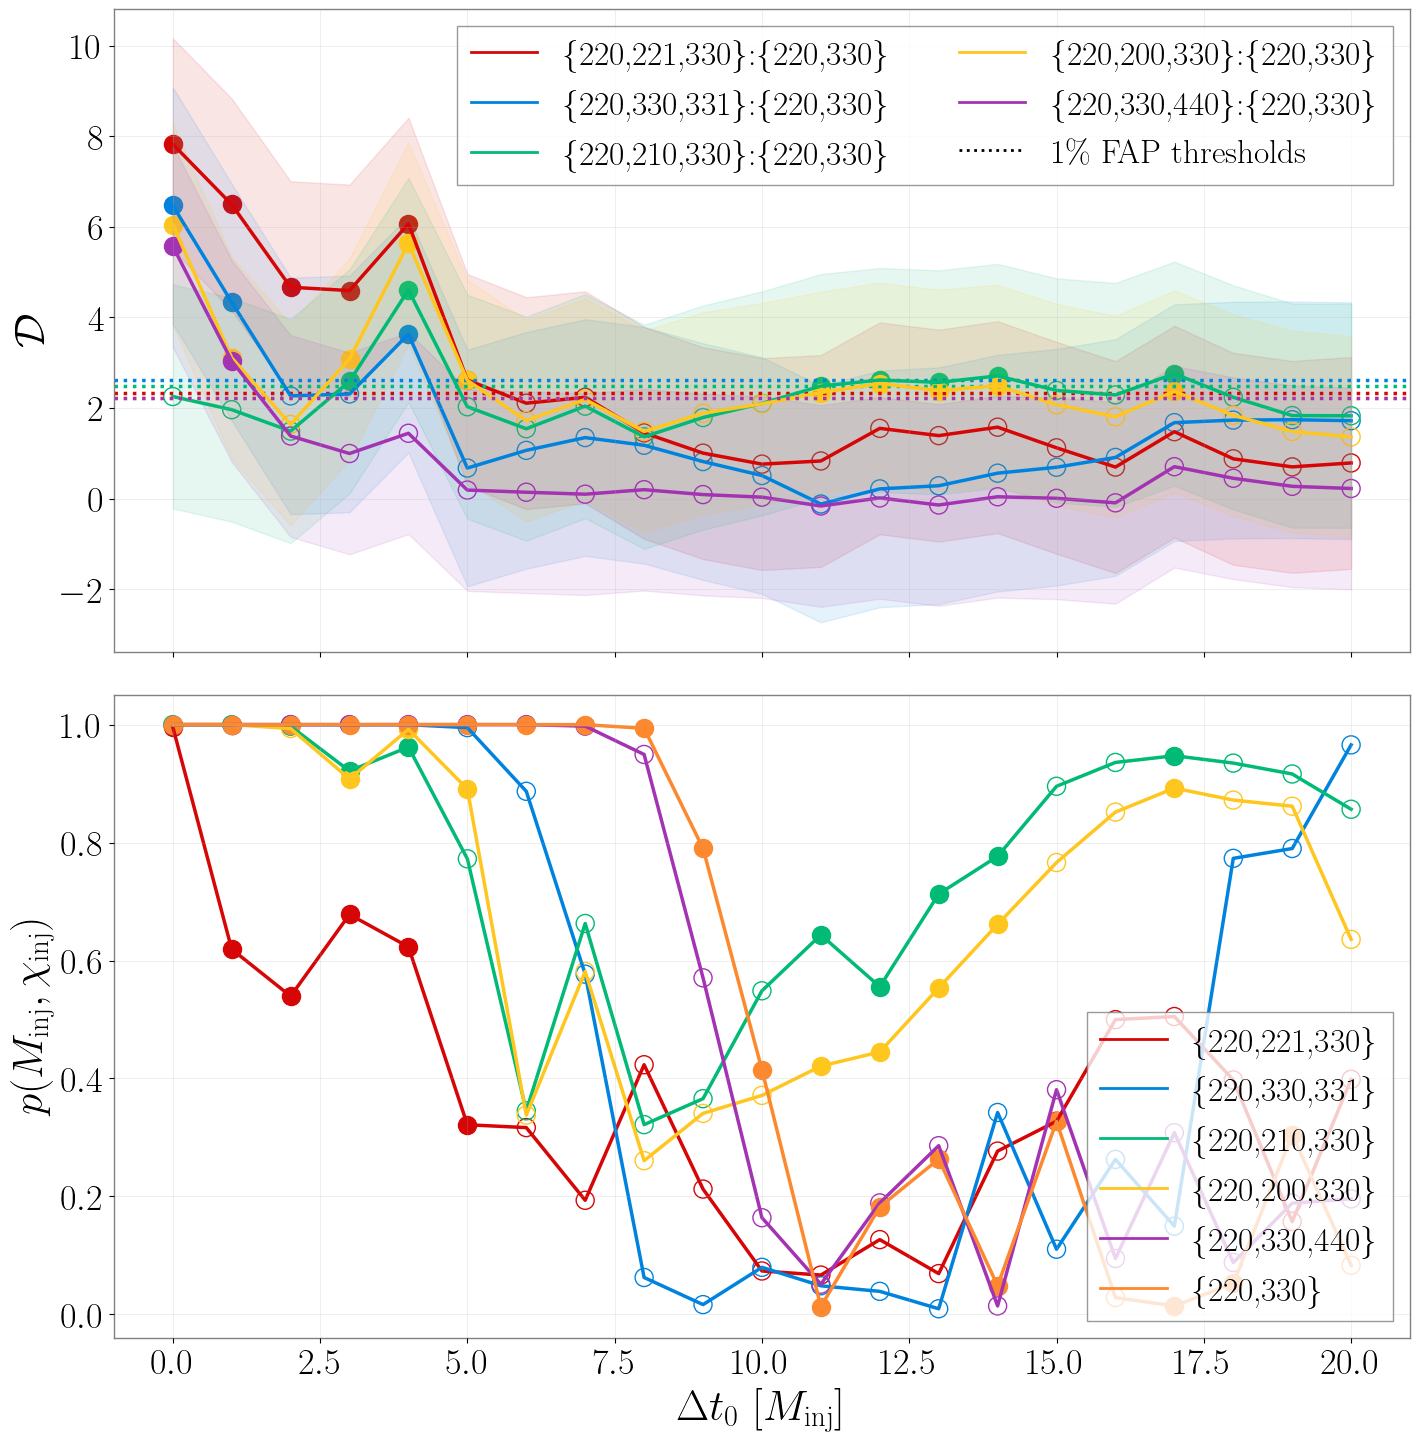

In [28]:
fig, axs = pl.subplots(2, sharex = True)
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
filename = "results/1107_3mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
ref_mode = '220+330'
plotting_label = ["\{220,221,330\}","\{220,330,331\}","\{220,210,330\}","\{220,200,330\}","\{220,330,440\}","\{220,330\}"]


time_arr = data[-1]
BF_curves = data[:-1]/np.log(10)
for idx, val in enumerate(BF_curves):
    thresh = thresh_dict[mode_list[idx]+':'+ref_mode]
    significant = val > thresh
    axs[0].plot(time_arr, val, label=plotting_label[idx]+':\{220,330\}', color=color_arr[idx])
    axs[0].scatter(time_arr[significant], val[significant], marker='o', color=color_arr[idx])
    axs[0].scatter(time_arr[np.logical_not(significant)], val[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[idx])
    axs[0].fill_between(time_arr, val-thresh, val+thresh,
                   alpha=0.1, color=color_arr[idx])
    axs[0].axhline(thresh,
                   alpha=1.0, color=color_arr[idx], ls=':')

axs[0].plot(np.nan, np.nan, ls=':', color = 'k', label='1\% FAP thresholds')
leg = axs[0].legend(ncols=2,fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel(r"$\mathcal{D}$")

filename = "results/1107_3mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]
for idx, val in enumerate(pvalues[:-1]):
    quantiles = val
    thresh = thresh_dict[mode_list[idx]+':'+ref_mode]
    significant = BF_curves[idx] > thresh
    axs[1].plot(time_arr, quantiles , label=plotting_label[idx], color=color_arr[idx])
    axs[1].scatter(time_arr[significant], quantiles[significant], marker='o', color=color_arr[idx])
    axs[1].scatter(time_arr[np.logical_not(significant)], quantiles[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[idx])
filename = "results/1107_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
time_arr = data[-1]
BF_curves = data[:-1]/np.log(10)
BF_dict = dict(zip(mode_list, BF_curves))

filename = "results/1107_3mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
time_arr = data[-1]
pvalues = data[:-1]
pvalue_dict = dict(zip(mode_list, pvalues))

#for the reference mode
ref_mode = "220+330"
thresh = thresh_dict[ref_mode+':220']
significant = BF_dict[ref_mode] > thresh
quantiles = pvalue_dict[ref_mode]

axs[1].plot(time_arr, quantiles , label=plotting_label[-1], color=color_arr[-1])
axs[1].scatter(time_arr[significant], quantiles[significant], marker='o', color=color_arr[-1])
axs[1].scatter(time_arr[np.logical_not(significant)], quantiles[np.logical_not(significant)], marker='o', facecolors='none', color=color_arr[-1])


leg = axs[1].legend(loc='lower right', fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ [$M_\textrm{\huge inj}$]')
axs[1].set_ylabel(r"$p(M_\textrm{\huge inj},\chi_\textrm{\huge inj})$")

pl.tight_layout()
pl.savefig("plots/1107_3mode_results.pdf")
pl.savefig("plots/1107_3mode_results.png")

## Contours

In [41]:
mode_arr[:-1]

['220', '220+221']

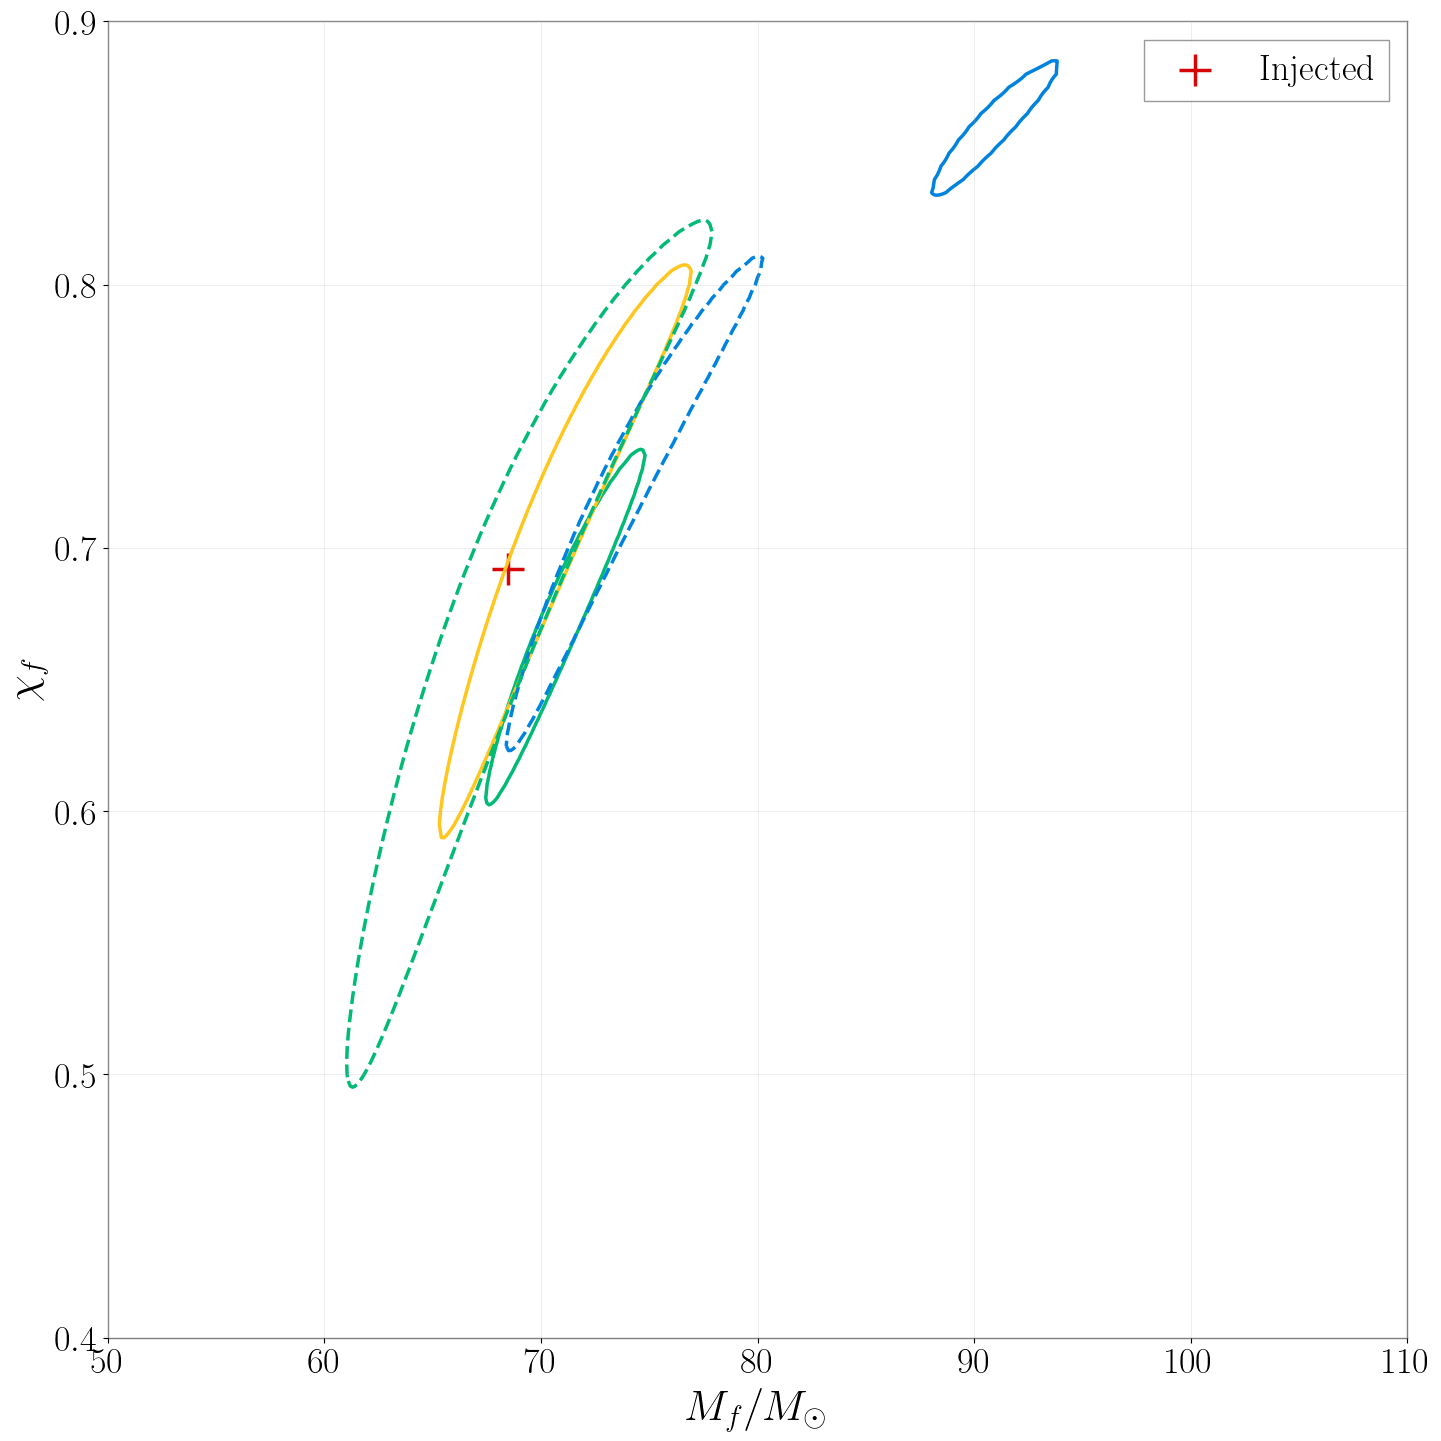

In [45]:
name = "SXS:BBH:0305"
remnant_mass = 68.5
remnant_chi = 0.692
mode_arr = ['220', '220+221','220+221+222']

for idx, mode in enumerate(mode_arr):
    likelihood_data, evidence, time_offset, credible, \
    chi_lower, chi_upper, mass_lower, mass_upper, \
    massspace, chispace, mass_grid, chi_grid, projected_mass, projected_chi = load_data(f"results/BBH_0305_realisation2_{mode}_t=1.0M.txt")
    pl.contour(mass_grid, chi_grid, likelihood_data, [credible], colors=[color_arr[idx+1]], linestyles='solid')
    
for idx, mode in enumerate(mode_arr[:-1]):
    likelihood_data, evidence, time_offset, credible, \
    chi_lower, chi_upper, mass_lower, mass_upper, \
    massspace, chispace, mass_grid, chi_grid, projected_mass, projected_chi = load_data(f"results/BBH_0305_realisation2_{mode}_t=11.0M.txt")
    pl.contour(mass_grid, chi_grid, likelihood_data, [credible], colors=[color_arr[idx+1]], linestyles='dashed')

pl.scatter(remnant_mass, remnant_chi, c=red, s = 500, marker='+', label='Injected')
pl.legend()
pl.xlabel(r'$M_f/M_\odot$')
pl.ylabel(r'$\chi_f$')
pl.ylim(0.4, 0.9)
pl.xlim(50, 110)
pl.tight_layout()